# Train a MLR model on the event stream as output of the DVS
## Makes a training set

In [14]:
%load_ext autoreload
%autoreload 2

from aprovhots import fit_MLR, predict_data#, score_classif_events, get_dataset_info, get_loader, fit_histo, predict_histo
from dataset_creation import Synthetic_Dataset
from HOTS.tools import score_classif_events, get_dataset_info, get_loader, fit_histo, predict_histo
from HOTS.network import network
import tonic #, os

path = '/home/INT/grimaldi.a/Documents/projets/WP3/2021-12-06_simulator_data/'
patch_size = (32,32)
max_duration = 1e3
date = '2022-01-03'
# we set tau_cla emprirically based on the ISI for SEA samples (see Make_dataset notebook)
tau_cla = 200*patch_size[0]*patch_size[1]*2

trainset = Synthetic_Dataset(save_to=path, train=True, patch_size=patch_size, max_duration=max_duration)
testset = Synthetic_Dataset(save_to=path, train=False, patch_size=patch_size, max_duration=max_duration)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
patch_(32, 32)_duration_1000.0/train/
patch_(32, 32)_duration_1000.0/test/


## weird things in the dataset:
- sometimes there is no event of one polarity when splitting in patches with max duration of 1s
- time steps in the dataset 

Had to be deleted with the previous function

number of samples in the trainset: 8528
number of samples in the testset: 4663
----------------------------------------
number of samples in each class for the trainset: [4788. 3740.]
number of samples in each class for the testset: [3444. 1219.]
----------------------------------------


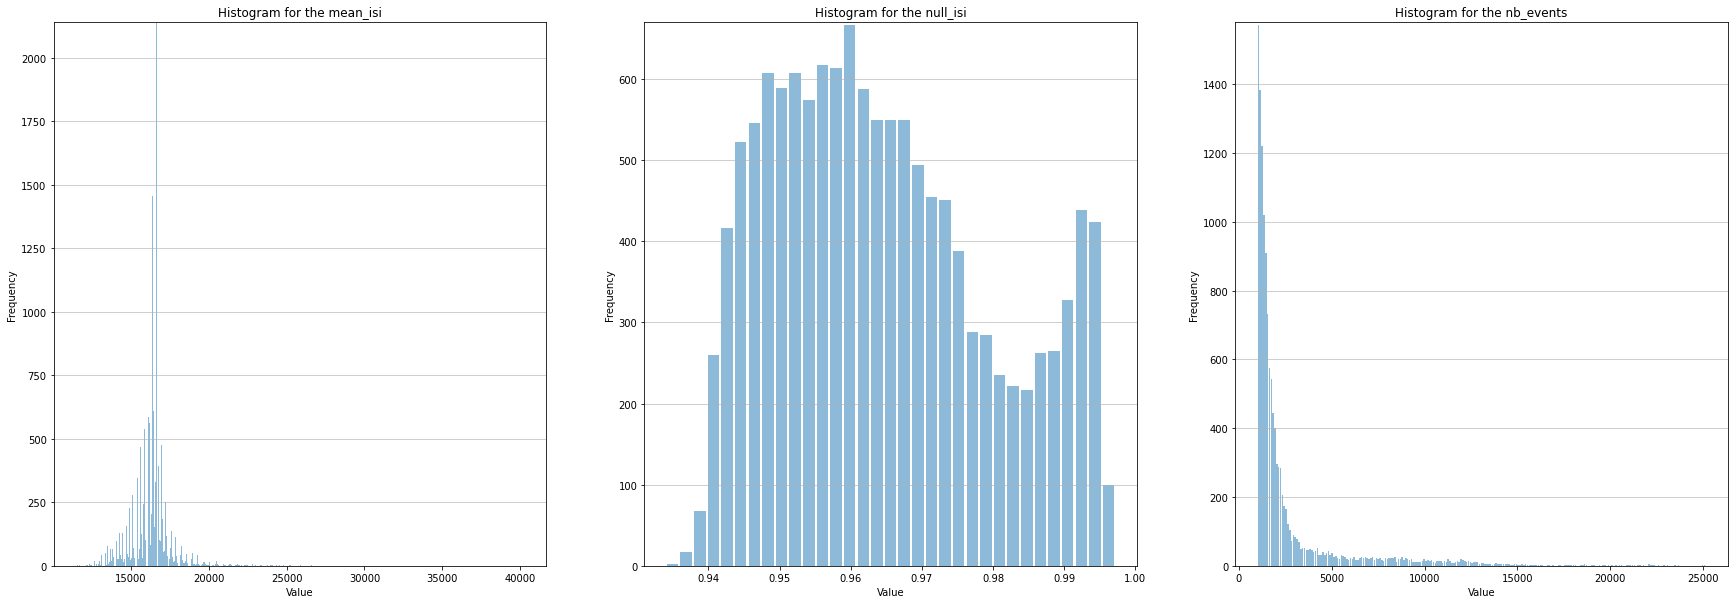

In [7]:
get_dataset_info(trainset, testset);

## Train MLR model on the raw stream of events

In [2]:
kfold = None
MLR_model, losses = fit_MLR(path, date, tau_cla, patch_size=patch_size, max_duration = max_duration, kfold=kfold)

../Records/models/2022-01-03_RAW_409600_(32, 32)_None_LR.pkl
load existing model


In [3]:
likelihood, true_target = predict_data(path, date, tau_cla, patch_size=patch_size, max_duration = max_duration, kfold=kfold)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4663/4663 [06:56<00:00, 11.19it/s]


Mean accuracy: 47.4%


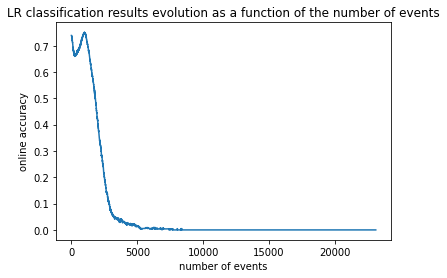

In [4]:
meanac, onlinac, lastac, truepos, falsepos = score_classif_events(likelihood, true_target)

### Higher threshold

In [5]:
meanac, onlinac, lastac, truepos, falsepos = score_classif_events(likelihood, true_target, thres=0.9)

Mean accuracy: 47.0%


## Train MLR model on the output of HOTS network (classic architecture)
### 1. Train the network

In [15]:
import numpy as np
kfold = 30
loader = get_loader(trainset, kfold=kfold)
print(f'Size of Dataloader: {len(loader)} samples')

Size of Dataloader: 284 samples


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[16]_[2.0]_[2].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[16]_[4.0]_[2].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[16]_[10.0]_[2].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[16]_[2.0]_[2].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[16]_[4.0]_[2].pkl


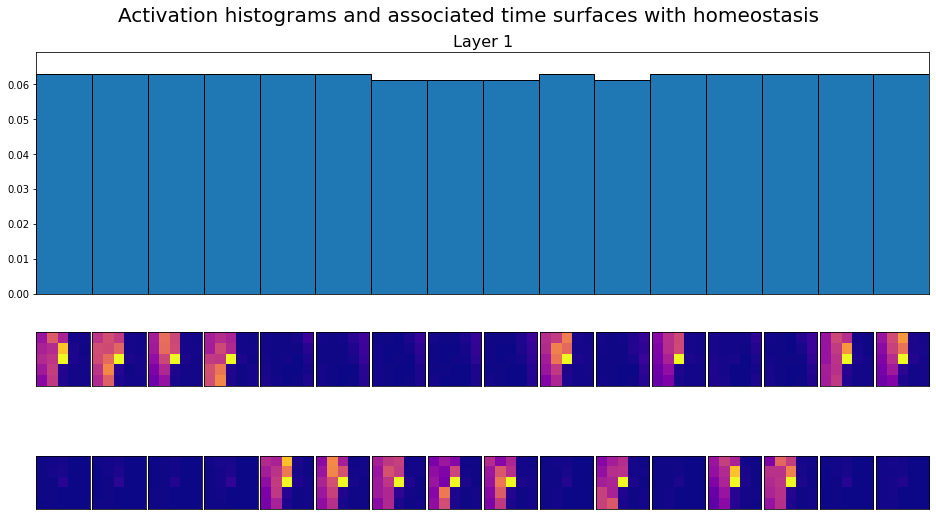

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[16]_[10.0]_[2].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 0.1)_[16]_[2.0]_[2].pkl



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [02:32<00:00,  1.86it/s]


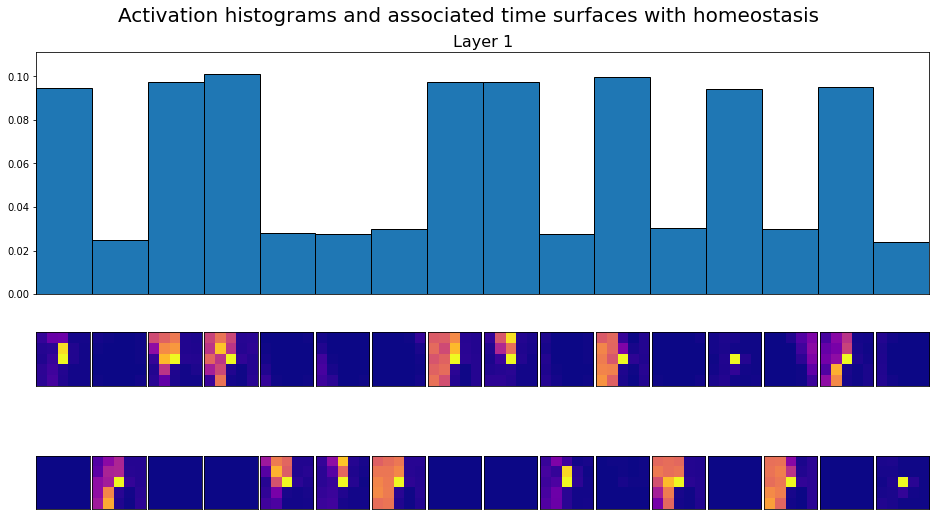


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [02:39<00:00,  1.78it/s]


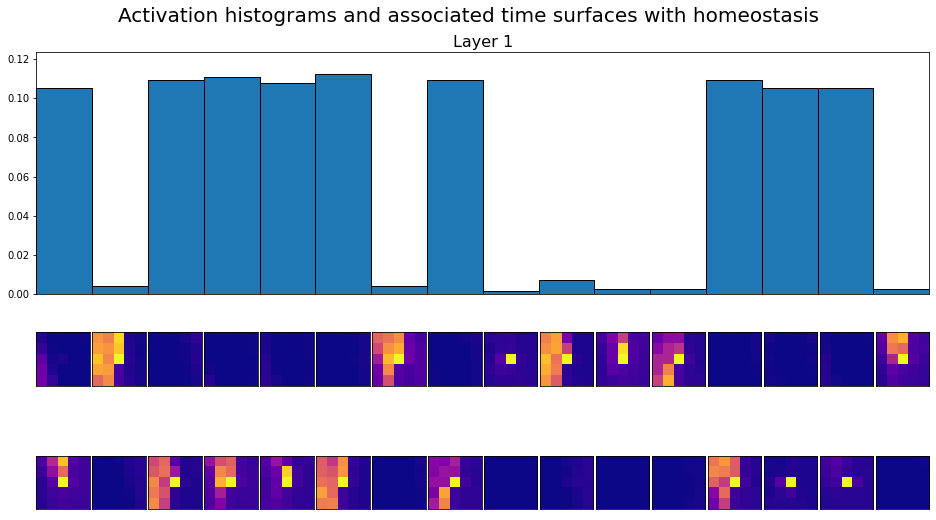


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [02:00<00:00,  2.35it/s]


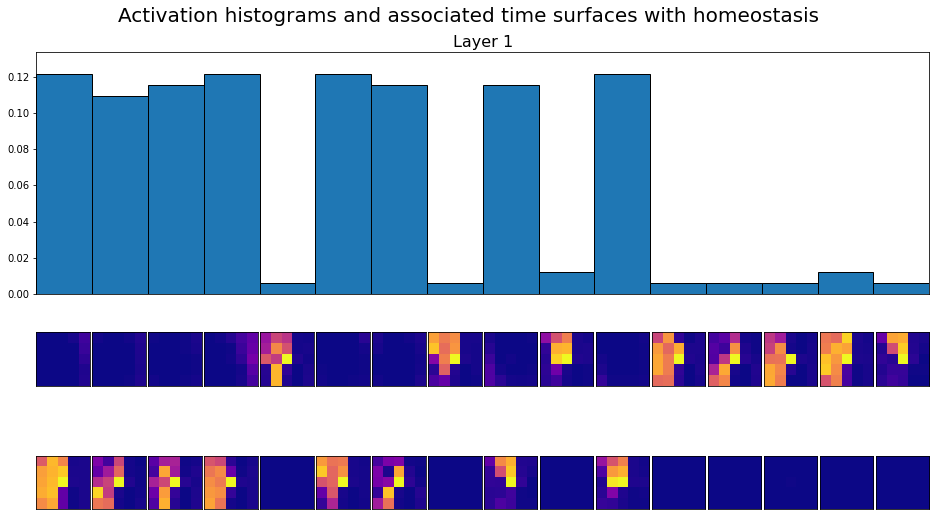


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [02:28<00:00,  1.91it/s]


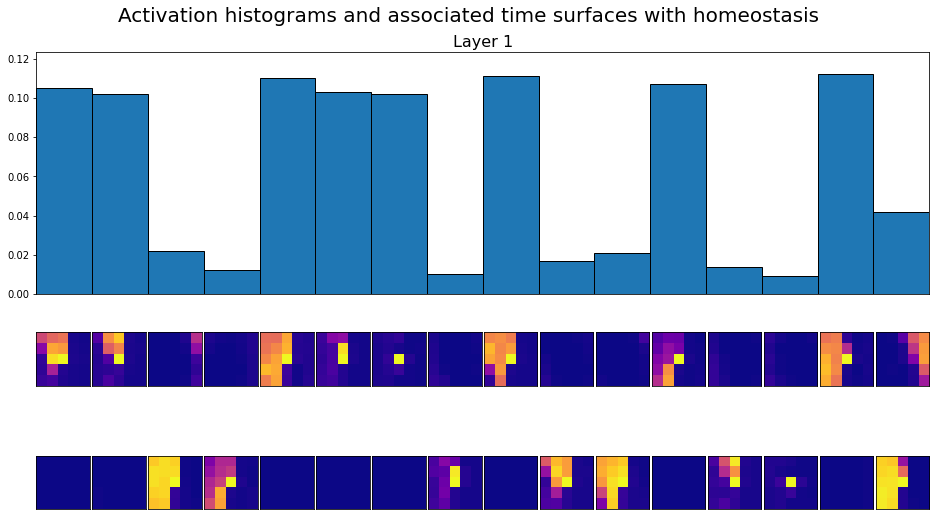


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [02:38<00:00,  1.79it/s]


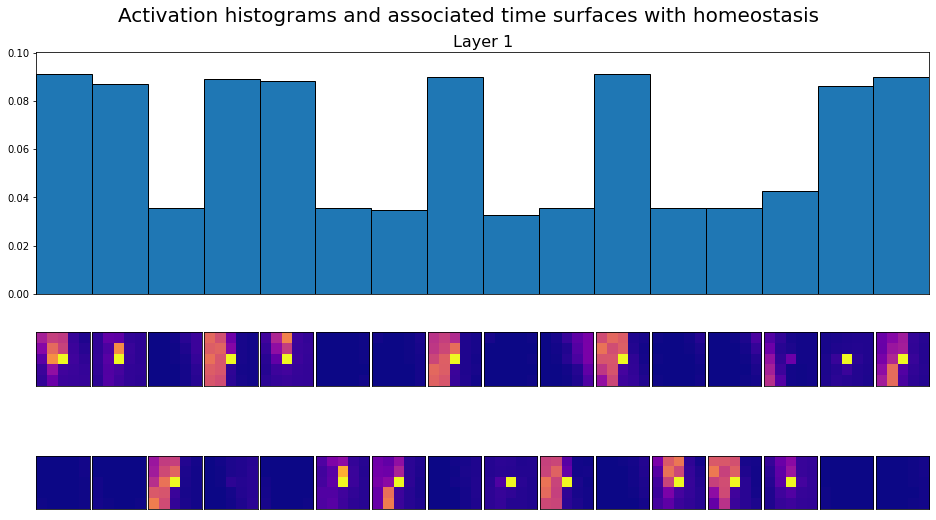

In [17]:
timestr = f'2022-01-17_synthetic_{patch_size}_{max_duration}'
name = 'homhots'

H = [(1,1),(1,2),(1,.1),(1,.2)]
tauz = [1,2,5]
accuracy = np.zeros([len(H), len(tauz)])
learn = True

for count_h, h in enumerate(H):
    for count_tau, prototau in enumerate(tauz):
        homeo = (h[0],h[1])
        tau = (prototau*2,)
        hots = network(name=name, tau=tau, homeo=homeo, timestr=timestr, camsize = patch_size, nbclust = (16,), R = (2,))
        hots.running(loader, trainset.ordering, trainset.classes, learn=learn)
        hots.plotlayer()
        #histo, label = fit_histo(hots)
        #accuracy[count_h,count_tau] = predict_histo(hots, histo, label, k=1)

In [22]:
print(accuracy)

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


In [14]:
loader = get_loader(trainset, kfold=30)
print(f'Size of Dataloader: {len(loader)} samples')
for h in [(1,1),(1,2),(1,.1),(1,.2)]:
    for prototau in [1,2,5]:
        homeo = (h[0],h[1])
        tau = (prototau*2,prototau*4,prototau*8)
        hots = network(name=name, tau=tau, homeo=homeo, timestr=timestr, camsize = patch_size)
        hots.running(loader, trainset.ordering, trainset.classes, learn=False)
        

Size of Dataloader: 284 samples
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[4, 8, 16]_[4.0, 8.0, 16.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[4, 8, 16]_[10.0, 20.0, 40.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[4, 8, 16]_[4.0, 8.0, 16.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic

In [15]:
loader = get_loader(testset, kfold=30)
print(f'Size of Dataloader: {len(loader)} samples')
for h in [(1,1),(1,2),(1,.1),(1,.2)]:
    for prototau in [1,2,5]:
        homeo = (h[0],h[1])
        tau = (prototau*2,prototau*4,prototau*8)
        hots = network(name=name, tau=tau, homeo=homeo, timestr=timestr, camsize = patch_size)
        hots.running(loader, trainset.ordering, trainset.classes, learn=False)

Size of Dataloader: 154 samples
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[4, 8, 16]_[4.0, 8.0, 16.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[4, 8, 16]_[10.0, 20.0, 40.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[4, 8, 16]_[4.0, 8.0, 16.0]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-17_synthetic

In [ ]:
histo, label = fit_histo(hots)

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.1, 0.1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


  2%|██▊                                                                                                                                   | 6/284 [18:05:04<837:55:07, 10850.75s/it]


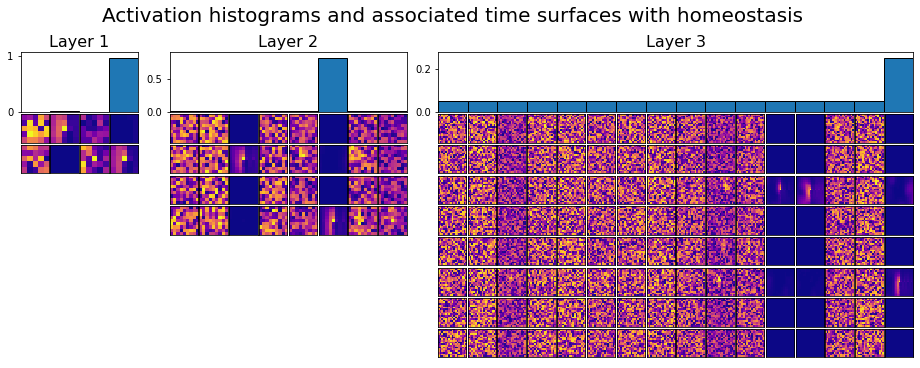

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.1, 0.2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in true_divide
  vrange /= ((a_max - a_min) / frac)


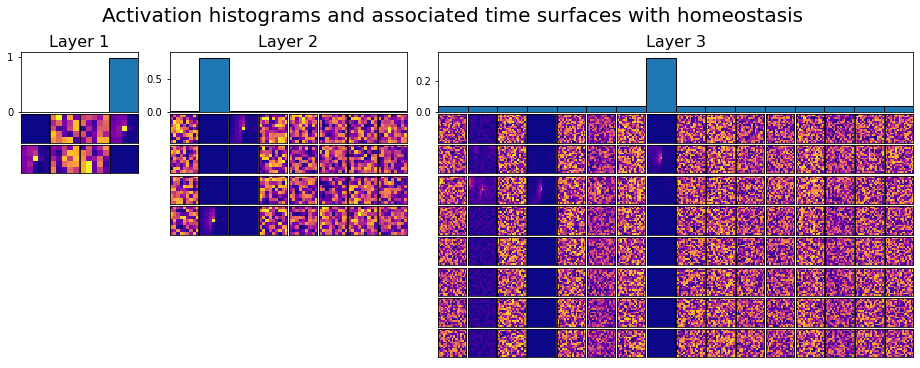

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.1, 0.5)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


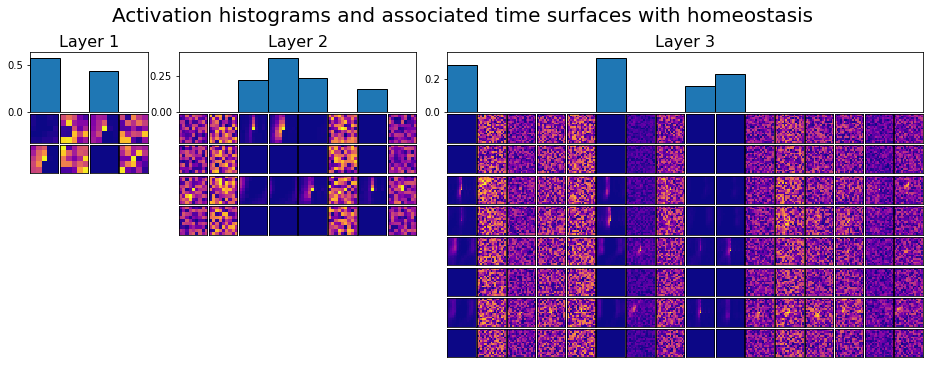

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.1, 1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


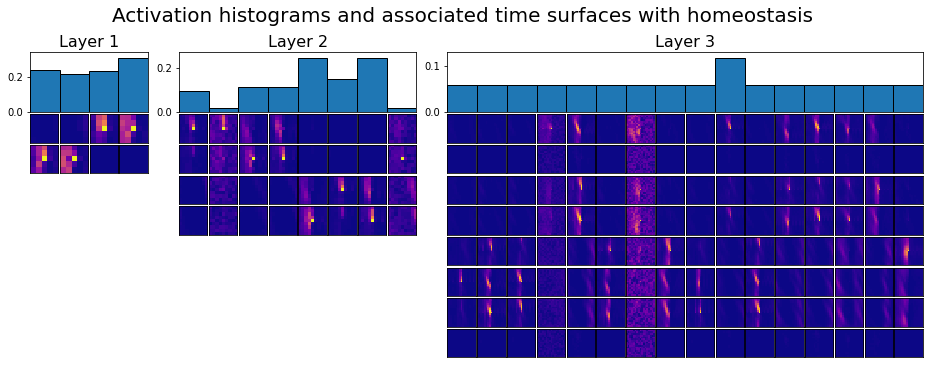

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.1, 2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


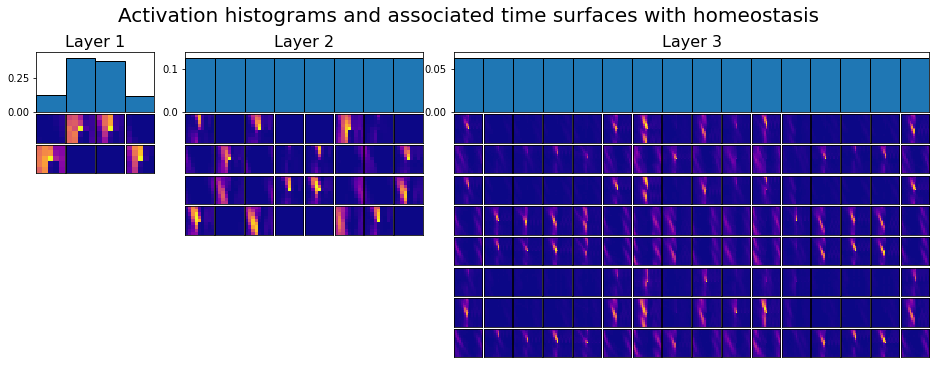

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.2, 0.1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.2, 0.2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


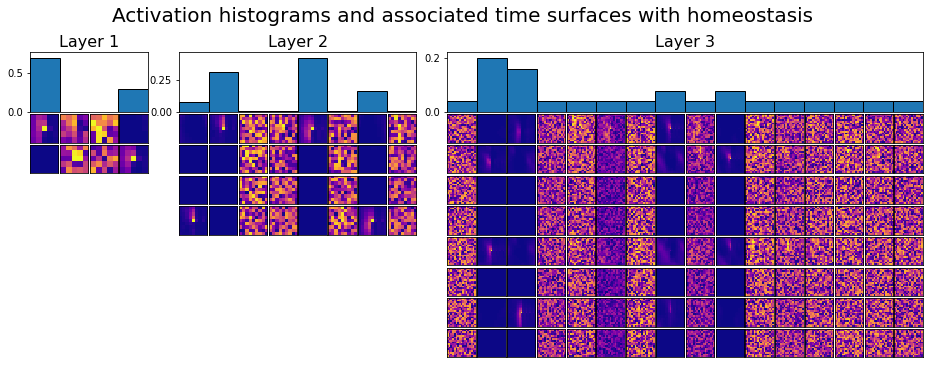

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.2, 0.5)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.2, 1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.2, 2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


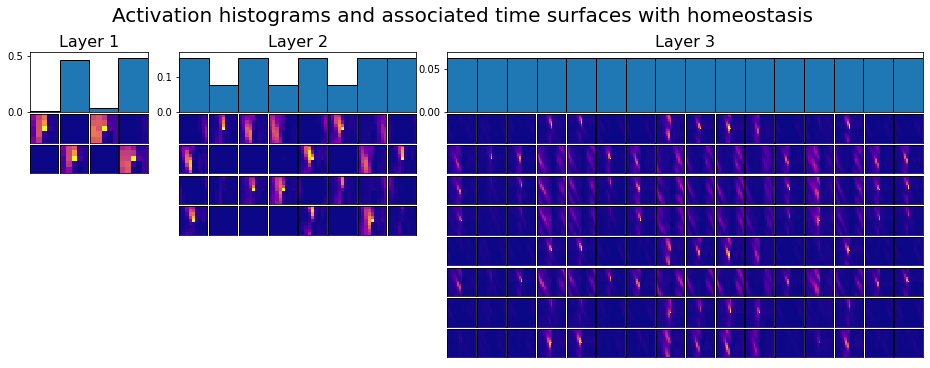

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.5, 0.1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


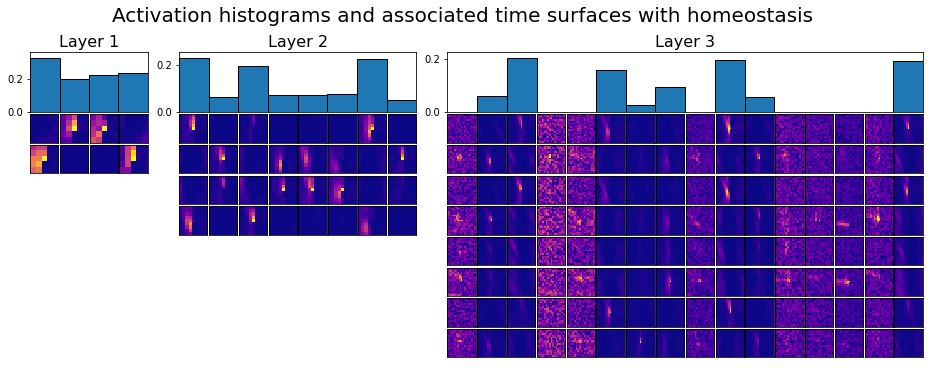

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.5, 0.2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.5, 0.5)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


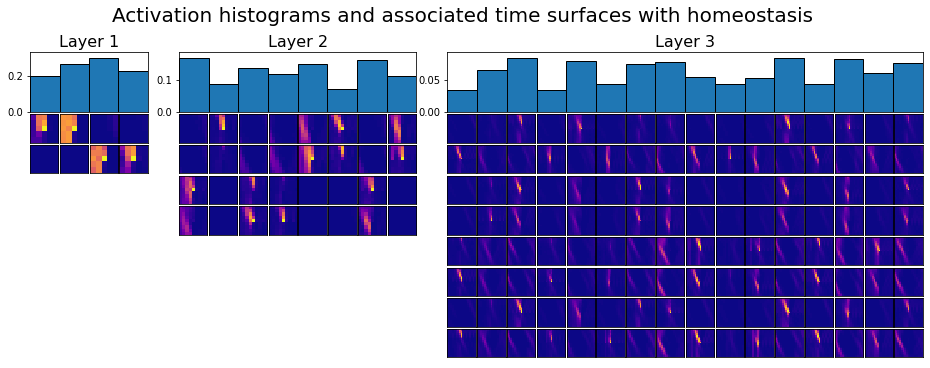

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.5, 1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


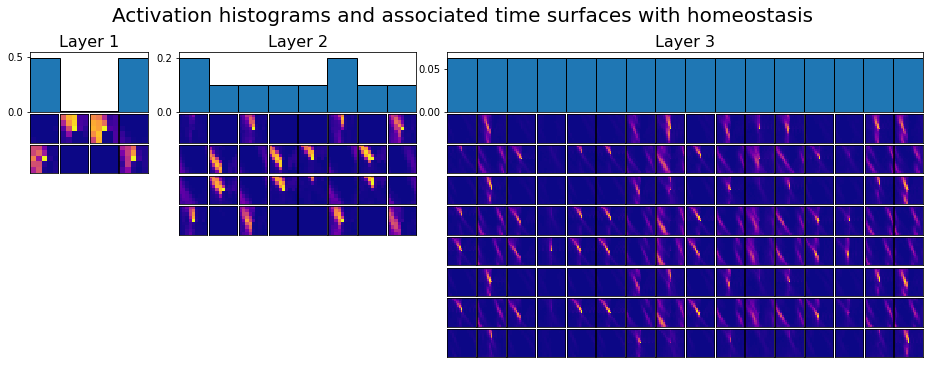

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(0.5, 2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 0.1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


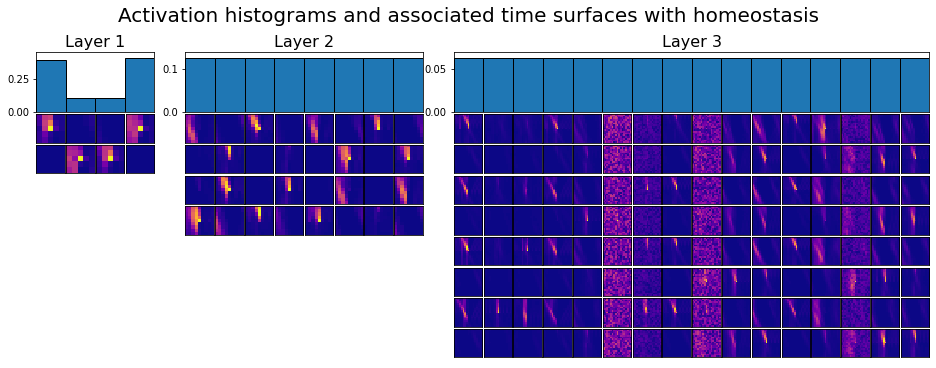

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 0.2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 0.5)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


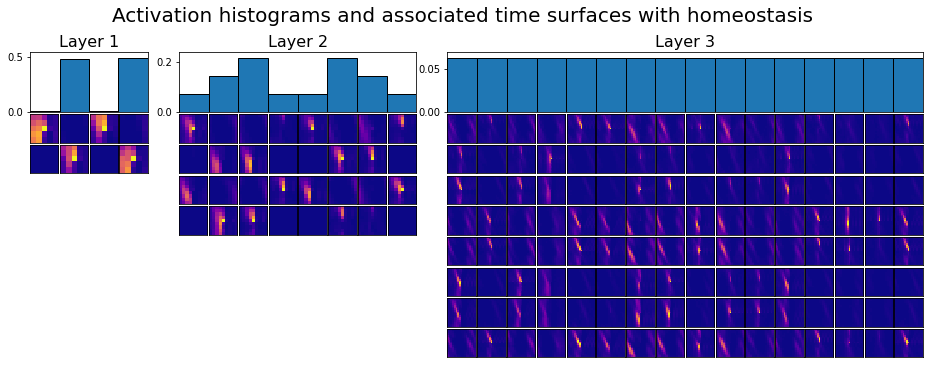

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


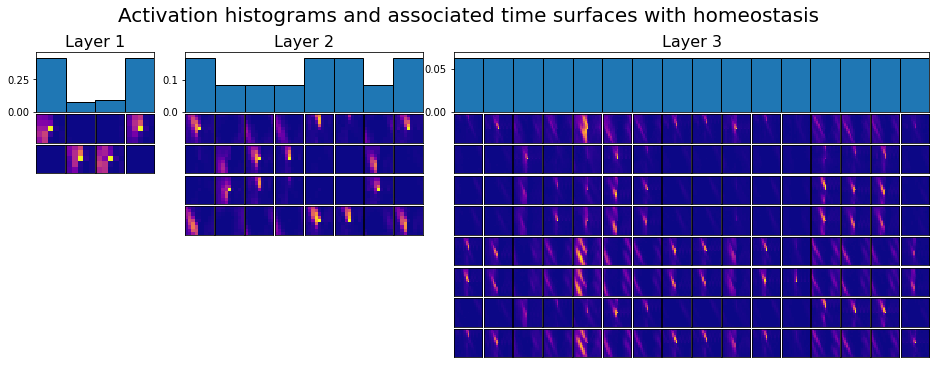

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(1, 2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(2, 0.1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


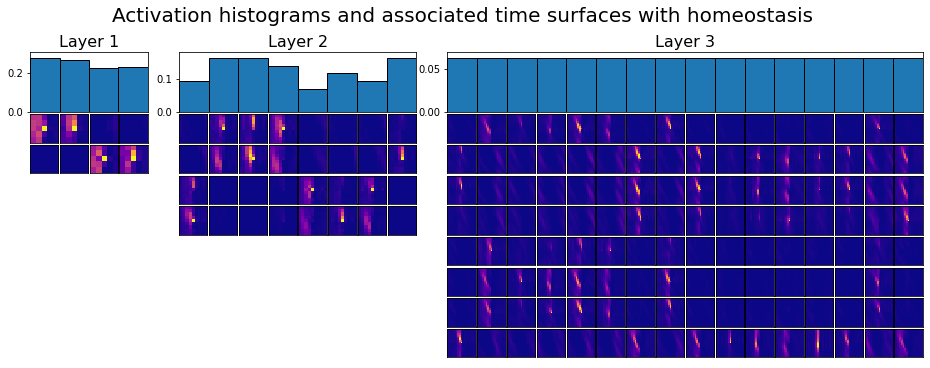

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(2, 0.2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


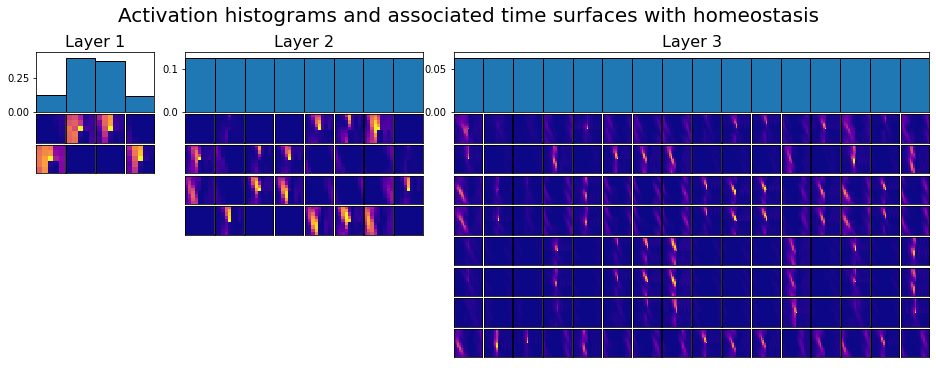

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(2, 0.5)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


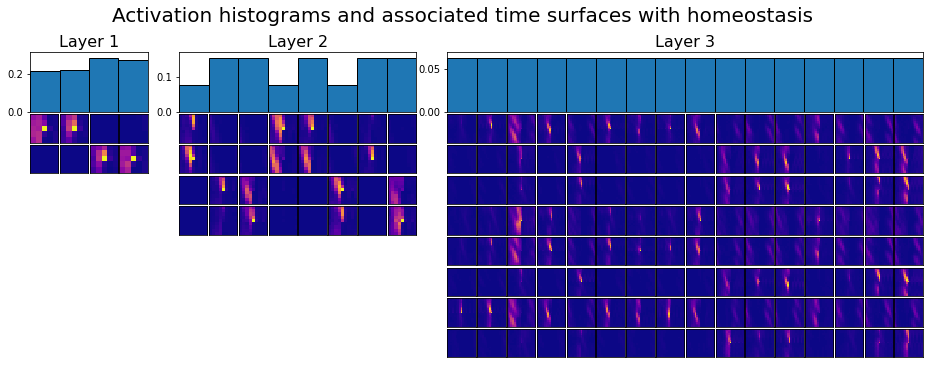

loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(2, 1)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


loading a network with name:
 ../Records/models/2022-01-17_synthetic_(32, 32)_1000.0_homhots_(2, 2)_[4, 8, 16]_[2.0, 4.0, 8.0]_[2, 4, 8].pkl


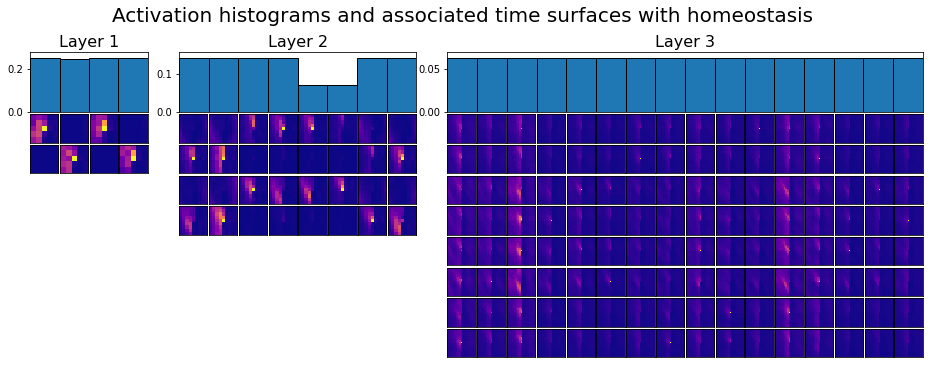


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [08:01<00:00,  1.70s/it]


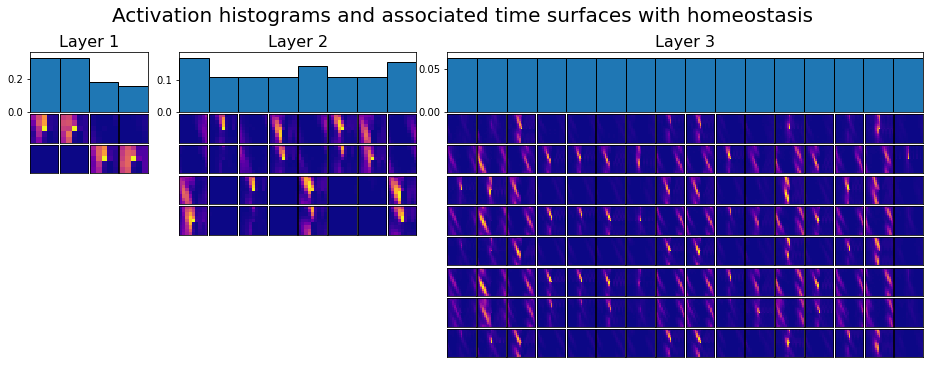


 44%|███████████████████████████████████████████████████████████████                                                                               | 126/284 [04:15<03:59,  1.52s/it]

KeyboardInterrupt: 

In [13]:
timestr = f'2022-01-17_synthetic_{patch_size}_{max_duration}'
name = 'homhots'
learn = True

for h1 in [.1,.2,.5,1,2,5,10]:
    for h2 in [.1,.2,.5,1,2]:
        for prototau in [1]:#[.01,.1,1,10,100,1000]:
            homeo = (h1,h2)
            tau = (prototau*2,prototau*4,prototau*8)
            hots = network(name=name, tau=tau, homeo=homeo, timestr=timestr, camsize = patch_size)
            hots.running(loader, trainset.ordering, trainset.classes, learn=learn)
            hots.plotlayer()